<a href="https://www.spe.org/events/en/2022/conference/22apog/asia-pacific-oil-and-gas-conference-and-exhibition.html"><img src = "https://www.spe.org/binaries/content/gallery/specms/speevents/organization-logos/spe-logo-2020.png" width = 200> 

<h1 align=center><font size = 5>Prediction of Recovery Factor using Machine Learning Methods</font></h1>

<h1 align=center><font size = 4> Munish Kumar, Kannapan Swaminathan</font></h1>
<h1 align=center><font size = 4> Part 3: Modelling</font></h1>
<h1 align=center><font size = 3> ERCE 2021 - 2022 </font></h1>

In [1]:
#!pip install pycaret --user
#!pip install mlflow --user

#### Libraries

In [2]:
# Only install the following libraries if you dont have it, otherwise leave it commented out

#!conda install -c anaconda natsort --yes
#!conda install -c anaconda xlrd --yes

# General Libraries
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import NullFormatter
import time
import re
import requests
import pickle
import seaborn as sns
import os
import glob
import sys
from natsort import natsorted
sns.set()

import plotly.graph_objects as go
import plotly.express as px
import warnings
warnings.filterwarnings('ignore')

# Sklearn Liraries
from sklearn import preprocessing

#Statistics Libraries
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

import datetime
from datetime import timedelta, date 
start = time.time()
%matplotlib inline

# Forces the print statement to show everything and not truncate
# np.set_printoptions(threshold=sys.maxsize) 
print('Libraries imported')

Libraries imported


###### Declare some global variables

In [3]:
dir_name = r'C:\Users\mkumar\Documents\GitHub\SPE_Paper\Final'
filename_suffix = 'csv'

In [4]:
file1 = 'CP3_SST_OIL_RF_data_4_Model'
#file2 = 'CP3a_SST_GAS_RF_data_4_Model'
#file3 = 'CP4_CARB_OIL_RF_data_4_Model'
#file4 = 'CP4a_CARB_GAS_RF_data_4_Model'

# File names above are hardwired; only fname needs to be changed to point to the relevant files.
fname = file1

##### Read in the data 

In [5]:
skiprows = 0

#Means read in the ',' as thousand seperator. Also drops all columns which are unnamed.
df = pd.read_csv(fname+'.'+filename_suffix, thousands=',', skiprows = skiprows)
df = df.loc[:, ~df.columns.str.contains('^Unnamed')] 
df.head()

5_Resource uncertainty    10_Region 11_Basin name  \
0                    1P        AFRICA  ABU GHARADIG   
1                    1P        AFRICA  ABU GHARADIG   
2                    1P        AFRICA   NIGER DELTA   
3                    1P        AFRICA   NIGER DELTA   
4                    1P   MIDDLE EAST        ZAGROS   

   38_Well count (total producer)  52_Well spacing (average) (ac)  \
0                            20.0                           140.0   
1                            20.0                           140.0   
2                            17.0                            89.0   
3                            22.0                             0.0   
4                           450.0                             0.0   

   70_Production rate (peak oil equivalent) (BOEPD) 72_Onshore or offshore  \
0                                            5000.0                ONSHORE   
1                                            5000.0                ONSHORE   
2                                            4201.0                ONSHORE   
3                                          241930.0               OFFSHORE   
4                                          108200.0                ONSHORE   

   75_Temperature (original) (deg. F)  76_Pressure_Temp_depth (ft TVDSS)  \
0                          232.000000                             9350.0   
1                          250.000000                             9650.0   
2                          191.608693                             6000.0   
3                          141.299534                             6000.0   
4                          190.000000                             6000.0   

   77_Pressure (original) (psi)  ...  \
0                   4500.000000  ...   
1                   4600.000000  ...   
2                   3122.000000  ...   
3                   6600.000000  ...   
4                   4452.278385  ...   

  117_Reservoir top subsea depth (ft TVDSS)  149_Reservoir period  \
0                                    9350.0            CRETACEOUS   
1                                    9650.0            CRETACEOUS   
2                                    2000.0               NEOGENE   
3                                    7772.0               NEOGENE   
4                                    7500.0     NEOGENE/PALEOGENE   

  170_Gross reservoir thickness (average) (ft)  176_Net/gross ratio (average)  \
0                                        240.0                           0.10   
1                                        500.0                           0.07   
2                                        110.0                           0.60   
3                                        200.0                           0.60   
4                                       1200.0                           0.36   

   204_Porosity (matrix average) (%)  218_API gravity (average) (deg. API)  \
0                               21.0                                  40.5   
1                               16.0                                  40.0   
2                               20.0                                  19.0   
3                               18.0                                  46.0   
4                               19.0                                  32.6   

   293_Original in-place oil equivalent (MMBOE)  \
0                                         166.0   
1                                         214.0   
2                                         160.0   
3                                        2100.0   
4                                       57300.0   

   225_Viscosity (oil average) (cp)  252_GOR (initial average) (SCF/STB)  \
0                             13.81                                850.0   
1                              4.74                                800.0   
2                              0.70                               1000.0   
3                              0.26                               1230.0   
4                              

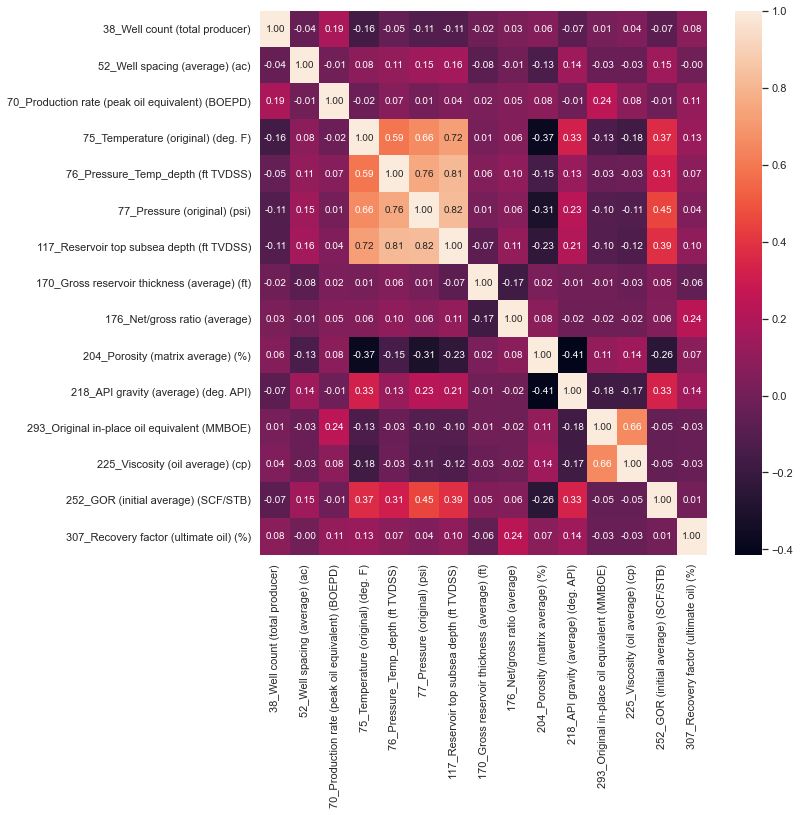

In [6]:
# Plot as Heat map to check for highly correlated variables
plt.figure(figsize=(10, 10))
ax = sns.heatmap(df.corr(), annot=True, fmt=".2f")

In observing the heat map above, I define highly correlated variables as having collinearity coeeficients of > 0.7. Therefore,

1. 75_ Temperature is highly correlatable to 117_Reservoir top subsea depth
2. 76_Pressure_Temp_Depth is highly correlatable to  117_Reservoir top subsea depth
3. 77_Pressure is highly correlatable to  117_Reservoir top subsea depth

As that the 117 variables do not add any additional information when it comes to predictive modelleing, I will drop 117 and 76 and recreate the heat map to check for correlation.

Note that dropping the variables makes sense, as reservoir top subsea depth should be physically linked to pressure and temperature in a reservoir

In [7]:
df_drop = df.drop(['117_Reservoir top subsea depth (ft TVDSS)',
                   '76_Pressure_Temp_depth (ft TVDSS)'
                  ], axis = 1)
plt.figure(figsize=(10, 10))
ax = sns.heatmap(df_drop.corr(), annot=True, fmt=".2f")

In [9]:
# Confirm properties of final dataframe
print(len(df_drop))
print(df_drop.info())
print(df_drop.describe(include='all'))
print(df_drop.columns.values)

712
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 712 entries, 0 to 711
Data columns (total 19 columns):
 #   Column                                            Non-Null Count  Dtype  
---  ------                                            --------------  -----  
 0   5_Resource uncertainty                            712 non-null    object 
 1   10_Region                                         712 non-null    object 
 2   11_Basin name                                     712 non-null    object 
 3   38_Well count (total producer)                    712 non-null    float64
 4   52_Well spacing (average) (ac)                    712 non-null    float64
 5   70_Production rate (peak oil equivalent) (BOEPD)  712 non-null    float64
 6   72_Onshore or offshore                            712 non-null    object 
 7   75_Temperature (original) (deg. F)                712 non-null    float64
 8   77_Pressure (original) (psi)                      712 non-null    float64
 9   82_Drive mechanis